In [2]:
'''Core updated as of March 7th  with Leonardo's fixes'''
import numpy as np
from numpy import random as npr
import pandas as pd
from matplotlib import pyplot as plt
import copy
import itertools
import seaborn as sns

In [3]:
# INITIAL DATA:_____________________________________________
cooperate = np.array( [ 1, 0 ] )
defect = np.array( [ 0, 1 ] )

# default Payoff matrix
default_R = 2
default_S = 0
default_T = 3
default_P = 1
Payoff = np.array( [ [ default_R , default_S ], [ default_T, default_P ] ] )

N_ROUNDS = 10

In [4]:
# NEW STRATEGIES:________________________________________________

# defining all strategies
# # template function
# parameter_list = [ k, ]
# def strategy( round_number = 0, match_history = [[]], player_index = 0 ) : 
#     # move either cooperate or defect
#     move
#     return move 

# nice guy function
def nice_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = cooperate
    return move 

# bad guy function
def bad_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = defect
    return move 

# percentage of defect for mainly nice ( and 1-k percentage of cooperate for mainly bad) Global Variable
k = 0.25

# mainly nice guy: randomly defect k% of the times and cooperate 100-k %, k<50
def mainly_nice( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u < k ) : move = defect
    else :         move = cooperate
    return         move

# mainly bad guy: randomly defect k% of the times and cooperate 100-k %, k>50
def mainly_bad( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u > k ) : move = defect
    else :         move = cooperate
    return         move

# random guy: randomly defect or cooperate
def random_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    u = npr.random( )
    if ( u < 0.5 ) : move = defect
    else :           move = cooperate
    return           move

# tit_for_tat function:  start by cooperating, then repeat what the opponent has done in the previous move
def tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) : 
    if ( round_number == 0 ) : move = cooperate
    else :                     move = match_history[ round_number - 1 ][ 1 - player_index ]
    return                     move

# resentful guy function: cooperate until the opponent defects once, then always defect
def resentful_guy( round_number = 0, match_history = [[]], player_index = 0 ) : 
    move = cooperate
    if ( round_number > 0 ) :
        for res in match_history : 
            # if any result matching a defect is found, the move is set to defect
            if np.array_equal( res[ 1 - player_index  ], defect ) : move = defect
            # if a defect is found, he would break    
            break
    return move

# trusting guy (increasing odds of cooperating according to match history):
# initially is like random guy (coop/defect at k=50%), then updates k
def trusting_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    # starting trust
    k_t = 0.5
    # environmental trust
    if ( round_number > 0 ) :
        # number of cooperative behaviour met
        coop = 0. 
        # increase the value of cooperation by one each cooperation (element 0) seen from the other player (index 1-player_index)
        for res in match_history : coop += res[ 1 - player_index  ][ 0 ]
        # normalizing result over the match history
        k_t = coop / len( match_history )
    u = npr.random( )
    if ( u > k ) : move = defect
    else :         move = cooperate
    return         move

# balancing guy (cooperates only for an even cooperation history)
def balancing_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    move = defect
    if ( round_number > 0 ) :
        # total cooperation seen
        coop = 0
        # increase the value of cooperation by one each cooperation (element 0) seen from each side during the match
        for res in match_history : coop += ( res[ 0 ][ 1 ] + res[ 1 ][ 1 ])
        if ( ( coop % 2 ) == 0 ) : move = cooperate
    return                         move

# Mid resentful: cooperates on the first move, and defects if the opponent has defected on any of the previous 3 moves, else cooperates
def mid_resentful( round_number = 0, match_history = [[]], player_index = 0):
    move = cooperate
    # selecting the oldest round to check, 3 before the current one if possible, the starting round otherwise
    start = max(0, round_number - 3)
    for round_i in range( start, round_number ):
        # checking if one of the previous move of the opponent (1-player_index) mach a defect
        if np.array_equal( match_history[round_i][1 - player_index], defect ):   
            move = defect
            # if a result is found, the cycle can break
            break
    return move

# reverse tit_for_tat function: start by defecting, then does the opposite of what the opponent has done in the previous move
def reverse_tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) : 
    if ( round_number == 0 ) : move = defect
                               # in this way i obtain the opposite move: [1,1] - [1,0] = [0,1] and [1,1] - [0,1] = [1,0]
    else :                     move = [1,1] - match_history[ round_number - 1 ][ 1 - player_index ]  
    return                     move

# learning to scam guy: start by defecting, then cooperating two times; for the following turns chose the optimal condition:
# if the opponent never defected, he will defect to scam the opponent
# if the opponent cooperated while he cooperated more than he was scammed, he will cooperate, because he sees some kind of intelligence
# otherwise he'll defect to avoid beeing scammed
def scamming_guy( round_number = 0, match_history = [[]], player_index = 0 ) :
    # default move is defect
    move =  defect
    # selecting first tree moves
    if ( round_number == 0 )   : 
        # print( f"round {round_number}: I defect" )
        move = defect
    elif ( round_number == 1 ) : 
        # print( f"round {round_number}: I cooperate" )
        move = cooperate
    elif ( round_number == 2 ) : 
        # print( f"round {round_number}: I cooperate" )
        move = cooperate
    else :
        # counting number of matching cooperation isses and defected from 0
        matching_coop = 0
        scammed = 0
        # deciding how much history to check
        first_r = npr.randint( 3, ( round_number + 1 ), dtype = int )
        # print( first_r )
        # searching over match history
        for i in range( round_number ) :
            # checking if the result cooperate, cooperate occurs
            if( np.array_equal( match_history[i][0], cooperate ) and np.array_equal( match_history[i][1], cooperate ) ) :
                matching_coop += 1
            # checking if the result cooperate, defect occurs in favour of the opposite side
            elif( np.array_equal( match_history[i][1 - player_index], defect ) and np.array_equal( match_history[i][player_index], cooperate ) ) :
                scammed += 1
        # checking if the opponent ever defected
        if( np.all( np.array_equiv( np.array( [ match_history[i][ 1 - player_index ] for i in range( ( round_number - first_r ), round_number ) ] ) , cooperate ) ) ) :
            # print( f"The rival is too good, I defect" )
            move = defect
        elif( matching_coop >= scammed ) : 
            # print( f"The rival is smart, I cooperate" )
            move = cooperate
    return move

# dictionary of all strategies
strategies = {
    'NiceGuy' : nice_guy,
    'BadGuy' : bad_guy,
    'MainlyNice' : mainly_nice,
    'MainlyBad' : mainly_bad,
    'TitForTat' : tit_for_tat,
    'RandomGuy' : random_guy,
    'ResentfulGuy' : resentful_guy,
    'TrustingGuy' : trusting_guy,
    'Thanos' : balancing_guy,
    'MidResentful': mid_resentful,
    'ReverseTft': reverse_tit_for_tat,
    'ScammingGuy' : scamming_guy,
}


In [5]:
# NEW MATCH DEFINING FUNCTIONS:________________________________________________

# function to play one round 1 vs 1 for two different* strategies players
def round( key_1, key_2, round_number, match_history, M = Payoff ) :
    # computing minimum and maximum reward for normalization
    s = np.dot( cooperate, M.dot(defect) )
    t = np.dot( defect, M.dot(cooperate) )
    # getting strategies from dictionary
    S_1 = strategies[ key_1 ]
    S_2 = strategies[ key_2 ]
    # computing next move for each player
    u_1 = S_1( round_number, match_history, 0 )
    u_2 = S_2( round_number, match_history, 1 )
    # computing rewards for each player
    r_1 = np.dot( u_1, M.dot(u_2))
    r_2 = np.dot( u_2, M.dot(u_1))
    # normalizing results
    r_1 = float( r_1 - s ) / float( t - s )
    r_2 = float( r_2 - s ) / float( t - s )
    # updating match history
    match_history.append( [ u_1, u_2 ] )
    # returning results
    return r_1, r_2

# function to play a match of N rounds 1 vs 1 for two different* strategies player
def match( key_1, key_2, N_rounds = 10, M = Payoff ) : 
    # match history strarting empty
    history = [ ]
    # starting total rewards
    R_1 = 0
    R_2 = 0
    # list of partial sums
    Rewards = []
    for round_i in range( 0, N_rounds ) :
        r_1, r_2 = round( key_1, key_2, round_i, history, M )
        R_1 += r_1
        R_2 += r_2
        #Rewards.append( [ R_1, R_2 ] )
        # normalizing results to round played up this moment
        Rewards.append( [ float(R_1)/(round_i+1), float(R_2)/(round_i+1) ] )
    # returns the history list of partial sums of rounds rewards
    return Rewards

## Tourney function ##
A tourney is a multiple player IPD, where several strategies play against each other in a roud-robin scheme.
In our implementation, each participant can implement a given strategy, with no restrictions to the number of total players or the frequency of each strategy (however with N players there are $ \begin{pmatrix} N \\ 2 \end{pmatrix}$ pairing combinations, so it scales with $N^2$ ).
Moreover, we consider the standard population the list of participants made of exactly 1 player for each defined strategy and the default payoff matrix $M$:
$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix} = 
\begin{pmatrix} 
2 & 0 \\
3 & 1 
\end{pmatrix}
$$

In [6]:
def tourney(participants={},N_rounds = 10, M = Payoff):
    # Retrieve only the names of the strategies repeated as many times as their frequency allows.
    player_list_from_dict = []
    for item in (list(participants.keys())):
        for i in range (participants[item]):
            player_list_from_dict.append(item)
    # Compute the combinations; List which will be used to have the scores of each match by the side of the two opponents
    list_with_scores = list(itertools.combinations(player_list_from_dict, 2))
    N_giornata = len(list_with_scores)
    # Loop over the combinations one by one
    for i in range (N_giornata):
        # Player1 and Player2 strategies
        player1 = list_with_scores[i][0]
        player2 = list_with_scores[i][1]
        # Initiliaze an empty list to store the results over the match
        AllRewards = []
        # Do the match between the two players and update the rewards; The ordered syntax for match is:
        # match( key_1, key_2, N_rounds = 10, M = Payoff ) : 
        AllRewards =  match(player1, player2, N_rounds, M)
        # Retrieve the final scores for Player1 and Player2 as the last element in the list
        R1, R2 = AllRewards[-1][0], AllRewards[-1][1]
        list_with_scores[i] += (R1,R2)
    # Un-comment the following print to debug
    #for item in list_with_scores: print(item)
    
    # Good, now each combination has the corresponding score: we now need to assign it to the respective players and calculate the final score
    strat = list(participants.keys())
    freq = [participants[key] for key in strat]
    named =[]
    # Add identification to the layer trough the use of a numerical value from 1 up to their frequency BUT PRESERVE THE ORDER
    for key,f in zip (strat,freq):
        for j in range(1,f+1):
            if (f!=0):
                named.append(key + str(j))
    # Compute the permutations preserving the order
    with_names = list(itertools.combinations(named,2))
    # Copy the scores for each match over to the ones with identification
    # In list_with_scores[I][J] we have: I = ordered number of the combination, and J:
    # J=0 is 1st strategy; J=1 is 2nd strategy; J=2 is Player1 score; J=3 is Player2 score
    for i in range (N_giornata): with_names[i] += (list_with_scores[i][2],list_with_scores[i][3] )
    # Un-comment the following print to debug
    #for item in with_names: print(item)

    # Compute the score for each named player and add it to the list
    FinalScores = []
    for player in named:
        SumOver1 = np.sum([ with_names[i][2] for i in range (N_giornata) if (with_names[i][0] == player) ])
        SumOver2 = np.sum([ with_names[i][3] for i in range (N_giornata) if (with_names[i][1] == player) ])
        # Normalize the score by the number of opponents in the tourney
        FinalScores.append( (SumOver1 + SumOver2)/(np.sum(freq)-1) )
    Results = named
    
    for i in range (len(Results)):
        Results[i] = (Results[i],FinalScores[i])

    return ( Results )    

In [7]:
# Tourney test
test_part ={ 
    'NiceGuy' : 1,
    'BadGuy' : 1,
    'MainlyNice' : 1,
    'MainlyBad' : 1,
    'RandomGuy' : 1,
    'TitForTat' : 1,
    'ResentfulGuy' : 1,
    'TrustingGuy' : 1,
    'Thanos' : 1,
    'MidResentful' : 1,
    'ReverseTft': 1,
    'ScammingGuy': 1,
}

result = tourney(test_part,N_rounds = N_ROUNDS, M = Payoff)
#for item in result: print(item)
print("Here's the Ranking for the top 12 players at the end of the tourney:")
# Sorted gives a copy, while using LIST.sort() does it in place.
Ranking = sorted(result,reverse=True, key=lambda x: x[1])
for item in (Ranking[:12]): print(f"{item[0]:<15} {item[1]:.3f}")

Here's the Ranking for the top 12 players at the end of the tourney:
BadGuy1         0.624
ScammingGuy1    0.515
ResentfulGuy1   0.512
Thanos1         0.506
MidResentful1   0.503
TitForTat1      0.494
MainlyBad1      0.482
ReverseTft1     0.482
TrustingGuy1    0.476
MainlyNice1     0.427
RandomGuy1      0.409
NiceGuy1        0.370


In [8]:
# Retrieve the participants to the tourney as the players with non-zero frequency: needed to avoid divisions by zero with the mean
labels = [ x for (x,f) in test_part.items() if f!=0 ]
# Get the name of the player, that is the strategy with numerical identifier
players = [ result[i][0] for i in range (len(result)) ]
# Get their respective scores
rewards = [ result[i][1] for i in range (len(result)) ]

mean_rewards= []
index = 0

for item in players:
    # Make it a string to apply the count method: returns the number of times a substring is included in the main string
    f = str(players).count(item)
    # Compute the mean of their rewards: since players in result are listed in strategy order this is valid
    mean = (np.sum(rewards[index:index+f]))/f
    mean_rewards.append(mean)
    index += f
mean_result = list(zip(labels, mean_rewards))
mean_ranking = sorted(mean_result,reverse=True, key=lambda x: x[1])
for item in mean_ranking: print(f"{item[0]:<15} {item[1]:.3f}")

BadGuy          0.624
ScammingGuy     0.515
ResentfulGuy    0.512
Thanos          0.506
MidResentful    0.503
TitForTat       0.494
MainlyBad       0.482
ReverseTft      0.482
TrustingGuy     0.476
MainlyNice      0.427
RandomGuy       0.409
NiceGuy         0.370


## Mean Tourney ##
Since not all strategies are deterministic and, therefore, players with the same strategy may perform differently, we want to see the effects of this stochasticity. In order to do that, with the mean tourney function we proceed by:
1) Averaging over the scores of the players with the same strategy, since it's how the strategy itself performs that we are interested in.
2) Averaging over multiple runs of the tourney with the same settings (e.g the list of participants and the payoff matrix).

In [9]:
def mean_tourney(participants={},N_rounds = 10, M = Payoff,repeats=10):
    # Retrieve the participants to the tourney as the players with non-zero frequency: needed to avoid divisions by zero with the mean
    labels = [ x for (x,f) in participants.items() if f!=0 ]
    mean_ranking = dict( [(l,[]) for l in labels ] )

    # Dictionary to store how many times each strategy comes 1st, 2nd or 3rd respectively
    top3 = { key:np.array([0,0,0]) for key in labels } 
    
    for j in range(0,repeats):
        result = tourney(participants, N_rounds,M)
        
        # Get the name of the player, that is the strategy with numerical identifier
        players = [ result[i][0] for i in range (len(result)) ]
        # Get their respective scores
        rewards = [ result[i][1] for i in range (len(result)) ]
        # Dictionary to store the result by strategy: order is the same as the ranking dictionary
        mean_rewards= dict( [(l,0) for l in labels ] )
        index = 0
        for item in labels:
            # Make it a string to apply the count method: returns the number of times a substring is included in the main string
            f = str(players).count(item)
            # Compute the mean of their rewards: since players in result are listed in strategy order this is valid
            mean = np.mean(rewards[index:index+f])
            mean_rewards[item] = mean
            index += f
        # Update the ranking dictionary with the score for each strategy averaged over all the players with the same strategy
        for key in (mean_ranking.keys()): mean_ranking[key].append(mean_rewards[key])
        # Retrieve the top 3 strategies and update the top3 dictionary: it's important to use .items() with the dictionary, since
        # without it the sorting defaults to sorting and returning the keys, which in this case would mean order them alphabetically
        ordered = sorted(mean_rewards.items(), reverse=True, key=lambda x: x[1])
        first, second, third = str(ordered[0][0]), str(ordered[1][0]), str(ordered[2][0])
        # Syntax: top3[strategy][placement: 0-->First, 1-->Second, 2-->Third]
        top3[first][0] += 1
        top3[second][1] += 1
        top3[third][2] += 1

    # Compute mean and its error for each strategy across all repetitions
    deg_of_freed = 0
    if (repeats >1): deg_of_freed = repeats - 1
    for key in mean_ranking.keys(): mean_ranking[key] = [ np.mean(mean_ranking[key]), np.std(mean_ranking[key], ddof=deg_of_freed)/np.sqrt(repeats) ]
    mean_df = pd.DataFrame(mean_ranking.values(),index=mean_ranking.keys(),columns=["Mean Score", "Mean Error"])
    
    # Optional: Express frequeny in top3 as percentages; values are numpy-array so operations are element-wise
    for key in top3.keys(): top3[key] = top3[key]/repeats*100
    top_df = pd.DataFrame(top3.values(),index=top3.keys(),columns=["First [%]", "Second [%]", "Third [%]"])
    
    return mean_df, top_df

In [10]:
mean_result_df, top3_df = mean_tourney(test_part,N_rounds = N_ROUNDS, M = Payoff,repeats=100)
pd.options.display.float_format = '{:.3f}'.format
# Concatenate dataframes to show them side by side and optionally sort them by the most frequent winner
display( pd.concat((top3_df.sort_values(by=["First [%]"],ascending=False), mean_result_df),axis=1) )

,First [%],Second [%],Third [%],Mean Score,Mean Error
BadGuy,93.000,7.000,0.000,0.589,0.016
MainlyBad,3.000,23.000,14.000,0.521,0.032
TrustingGuy,3.000,20.000,14.000,0.516,0.034
ResentfulGuy,1.000,21.000,22.000,0.524,0.023
NiceGuy,0.000,0.000,0.000,0.349,0.018
MainlyNice,0.000,0.000,0.000,0.420,0.030
RandomGuy,0.000,3.000,8.000,0.470,0.040
TitForTat,0.000,0.000,0.000,0.494,0.010
Thanos,0.000,0.000,0.000,0.478,0.011
MidResentful,0.000,20.000,33.000,0.529,0.014


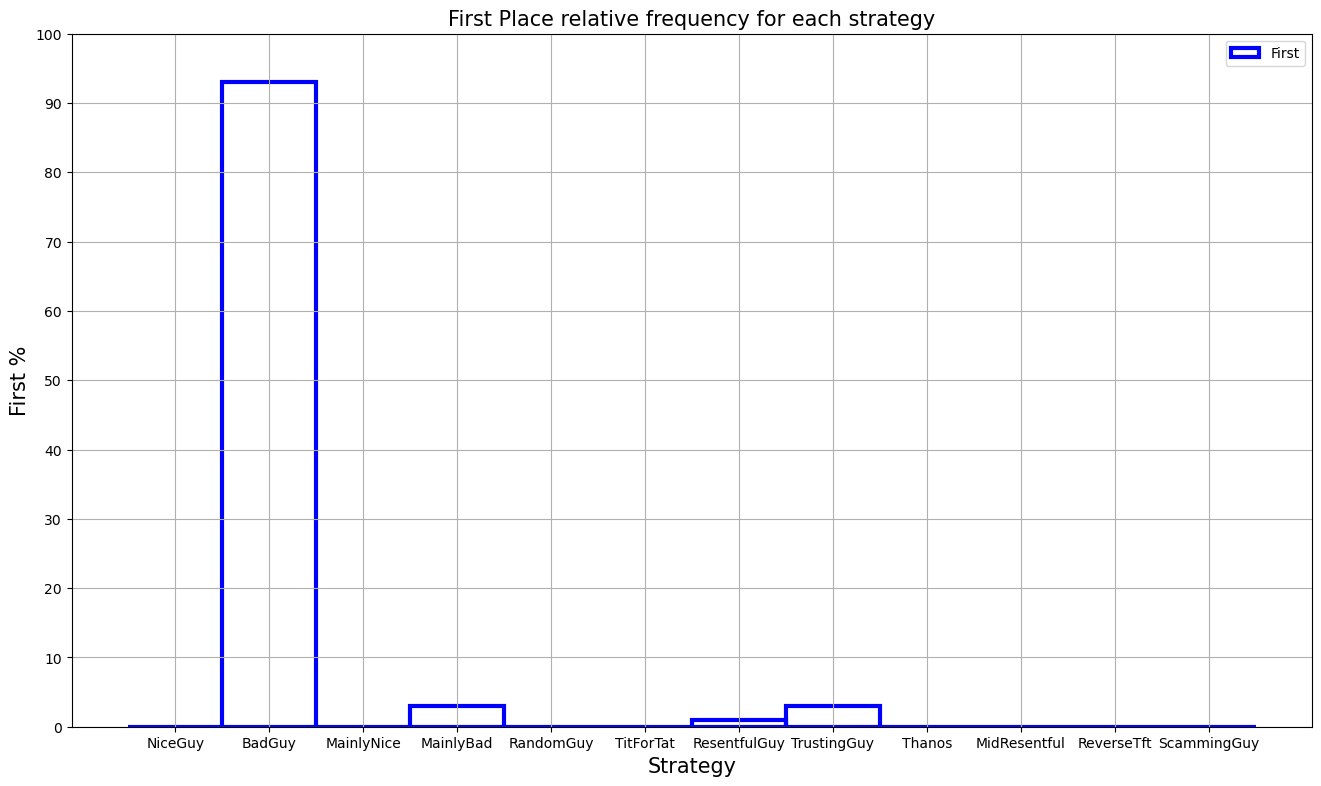

In [11]:
#display(top3_df)
fig, ax = plt.subplots(figsize=(16,9))
centers = np.arange(0,len(top3_df))
labels = list(top3_df.index.values)
freq = top3_df["First [%]"]
#freq2 = top3_df["Second [%]"]
#ax.scatter(centers,freq)
ax.set_xticks(ticks=centers, labels=labels)
ax.set_ylim(0,100)
ax.set_yticks(np.arange(0,101,10))
ax.grid()
ax.set_xlabel("Strategy", fontsize=15)
ax.set_ylabel("First %", fontsize =15)
plt.bar(labels,freq,1,edgecolor="blue",label="First",fill=False,ls="-",lw=3)
#plt.bar(labels,freq2,1,edgecolor="orange",label="Second",fill=False,ls="-",lw=3)
ax.legend()
ax.set_title("First Place relative frequency for each strategy", fontsize=15)
plt.show()

In [12]:
# Syntax [T,R,P,S] : Check if the given combination is eligible as a payoff matrix and, if so, build it 
def get_new_Payoff(par_list=[3,2,1,0]):
    if (len(par_list)!= 4):
        raise TypeError("Invalid parameter list for Payoff matrix")
    new_R = par_list[1]
    new_S = par_list[3]
    new_T = par_list[0]
    new_P = par_list[2]
    # Sanity checks
    if (np.min(par_list)!=new_S): raise ValueError("Parameters do not satisfy boundary conditions: S is not the smallest value")
    if (new_S == new_P): raise ValueError("Parameters do not satisfy boundary conditions: S is not strictly smaller than P")
    if (np.max(par_list)!=new_T): raise ValueError("Parameters do not satisfy boundary conditions: T is not the biggest value")
    if (new_R == new_T): raise ValueError("Parameters do not satisfy boundary conditions: T is not strictly greater than R")
    if (new_P >= new_R): raise ValueError("Parameters do not satisfy boundary conditions: R is not greater than P")
    if (2*new_R <= new_T + new_S ): raise ValueError("Parameters do not satisfy boundary conditions: 2R is not greater than T+S")
    return np.array([ [ new_R , new_S ], [ new_T, new_P ] ])

# We will use this function to generate all possible [T,R,P,S] for the payoff matrix given a maximum T and, optionally, a maximum R;
# with max_only==False we get all combinations with T up to max T, with max_only==True we only get the combinations with T=max_T
def test_parameters(max_T,max_R=0,max_only=False):
    if(max_only==False):
        if (max_R == 0): max_R = int(max_T -1)
        set_of_parameters = []
        for t in range (3,max_T+1):
            max_coop = np.minimum(t-1,max_R)
            for r in range (2,max_coop+1):
                value = np.maximum(0,2*r-t)
                possible_S = np.arange(0,value,1)
                for s in possible_S :
                    possible_P = np.arange(s+1,r,1)
                    for p in possible_P : 
                        set_of_parameters.append(( t, r, p, s )) 
        # Create a structured array in order to sort the results prioritizing T>R>P>S
        dtype = [('T', int), ('R', int), ('P', int), ('S', int)]
        matrix = np.array(set_of_parameters, dtype=dtype )
        matrix.sort(axis=0, order=['T','R','P','S'])
        set_of_parameters = []
        for item in matrix:
            set_of_parameters.append(list(item))
    else:
        if (max_R == 0): max_R = int(max_T -1)
        set_of_parameters = []
        t = max_T
        max_coop = np.minimum(t-1,max_R)
        for r in range (2,max_coop+1):
            value = np.maximum(0,2*r-t)
            possible_S = np.arange(0,value,1)
            for s in possible_S :
                possible_P = np.arange(s+1,r,1)
                for p in possible_P : 
                    set_of_parameters.append(( t, r, p, s ))
        # Create a structured array in order to sort the results prioritizing T>R>P>S
        dtype = [('T', int), ('R', int), ('P', int), ('S', int)]
        matrix = np.array(set_of_parameters, dtype=dtype )
        matrix.sort(axis=0, order=['T','R','P','S'])
        set_of_parameters = []
        for item in matrix:
            set_of_parameters.append(list(item))
        
    return (np.array(set_of_parameters))

In [13]:
# Sanity check
p_t = test_parameters(10)
for item in p_t:
    assign_test = get_new_Payoff(item)
    #print(f"{item} is ok")

# Retrieve the matrix values with the highest tested parameter
biggest_T = p_t[p_t[:,0]==p_t[-1,0]]
#print(biggest_T)

# Get the coefficients with the biggest disparity between T (succesfully defecting) and R (succesfully cooperating) and high P (both defect):
# we want to see what happens when we heavily incentivise defecting
#TR_gap = int(biggest_T[0,0]-biggest_T[0,1])
Promote_Defect = get_new_Payoff([10,6,5,1])
# Get the coefficients with the least disparity between T (succesfully defecting) and R (succesfully cooperating) and P is low, with S as
#high as possible: we want to see what happens when defecting is discouraged
Discourage_Defect = get_new_Payoff([10,9,1,0])

# Get the payoff matrix of the type [N, N-1, N-2, N-3] with N the biggest T in p_t; in this case it's [10, 9, 8, 7]
Sequential = get_new_Payoff(biggest_T[-1])

print("With Promote Defect payoff matrix:\n", Promote_Defect)
result_Promote_Defect, Promote_Defect_top3 = mean_tourney(test_part,N_rounds = N_ROUNDS, M = Promote_Defect, repeats=100)
# For our analysis, the strategy that gets first the most time is the most important information
display( pd.concat( (Promote_Defect_top3.sort_values(by=["First [%]"],ascending=False), result_Promote_Defect),axis=1) )

print("With Discourage Defect payoff matrix:\n", Discourage_Defect)
result_Discourage_Defect, Discourage_Defect_top3 = mean_tourney(test_part,N_rounds = N_ROUNDS, M = Discourage_Defect,repeats=100)
display( pd.concat( (Discourage_Defect_top3.sort_values(by=["First [%]"],ascending=False), result_Discourage_Defect),axis=1) )

print("With Sequential payoff matrix:\n", Sequential)
result_Sequential, Sequential_top3 = mean_tourney(test_part,N_rounds = N_ROUNDS, M = Sequential,repeats=100)
display( pd.concat( (Sequential_top3.sort_values(by=["First [%]"],ascending=False), result_Sequential),axis=1) )

With Promote Defect payoff matrix:
 [[ 6  1]
 [10  5]]


,First [%],Second [%],Third [%],Mean Score,Mean Error
BadGuy,99.000,1.000,0.000,0.658,0.013
TrustingGuy,1.000,40.000,25.000,0.560,0.032
NiceGuy,0.000,0.000,0.000,0.291,0.014
MainlyNice,0.000,0.000,0.000,0.388,0.034
MainlyBad,0.000,46.000,30.000,0.563,0.026
RandomGuy,0.000,0.000,2.000,0.476,0.035
TitForTat,0.000,0.000,0.000,0.482,0.006
ResentfulGuy,0.000,8.000,11.000,0.516,0.033
Thanos,0.000,0.000,0.000,0.508,0.009
MidResentful,0.000,2.000,16.000,0.536,0.011


With Discourage Defect payoff matrix:
 [[ 9  0]
 [10  1]]


,First [%],Second [%],Third [%],Mean Score,Mean Error
ResentfulGuy,35.000,23.000,19.000,0.522,0.022
TitForTat,28.000,26.000,24.000,0.522,0.021
MidResentful,13.000,19.000,17.000,0.509,0.023
MainlyNice,11.000,14.000,11.000,0.483,0.046
RandomGuy,7.000,4.000,5.000,0.461,0.051
MainlyBad,4.000,6.000,8.000,0.454,0.045
TrustingGuy,1.000,3.000,4.000,0.440,0.043
ScammingGuy,1.000,3.000,8.000,0.475,0.026
NiceGuy,0.000,2.000,4.000,0.470,0.023
BadGuy,0.000,0.000,0.000,0.443,0.022


With Sequential payoff matrix:
 [[ 9  7]
 [10  8]]


,First [%],Second [%],Third [%],Mean Score,Mean Error
BadGuy,86.000,14.000,0.000,0.591,0.016
MainlyBad,6.000,19.000,16.000,0.526,0.031
TrustingGuy,6.000,21.000,14.000,0.523,0.035
ResentfulGuy,2.000,22.000,20.000,0.522,0.025
NiceGuy,0.000,0.000,0.000,0.348,0.018
MainlyNice,0.000,0.000,0.000,0.423,0.039
RandomGuy,0.000,0.000,5.000,0.468,0.036
TitForTat,0.000,0.000,1.000,0.496,0.010
Thanos,0.000,0.000,0.000,0.479,0.012
MidResentful,0.000,19.000,29.000,0.527,0.014


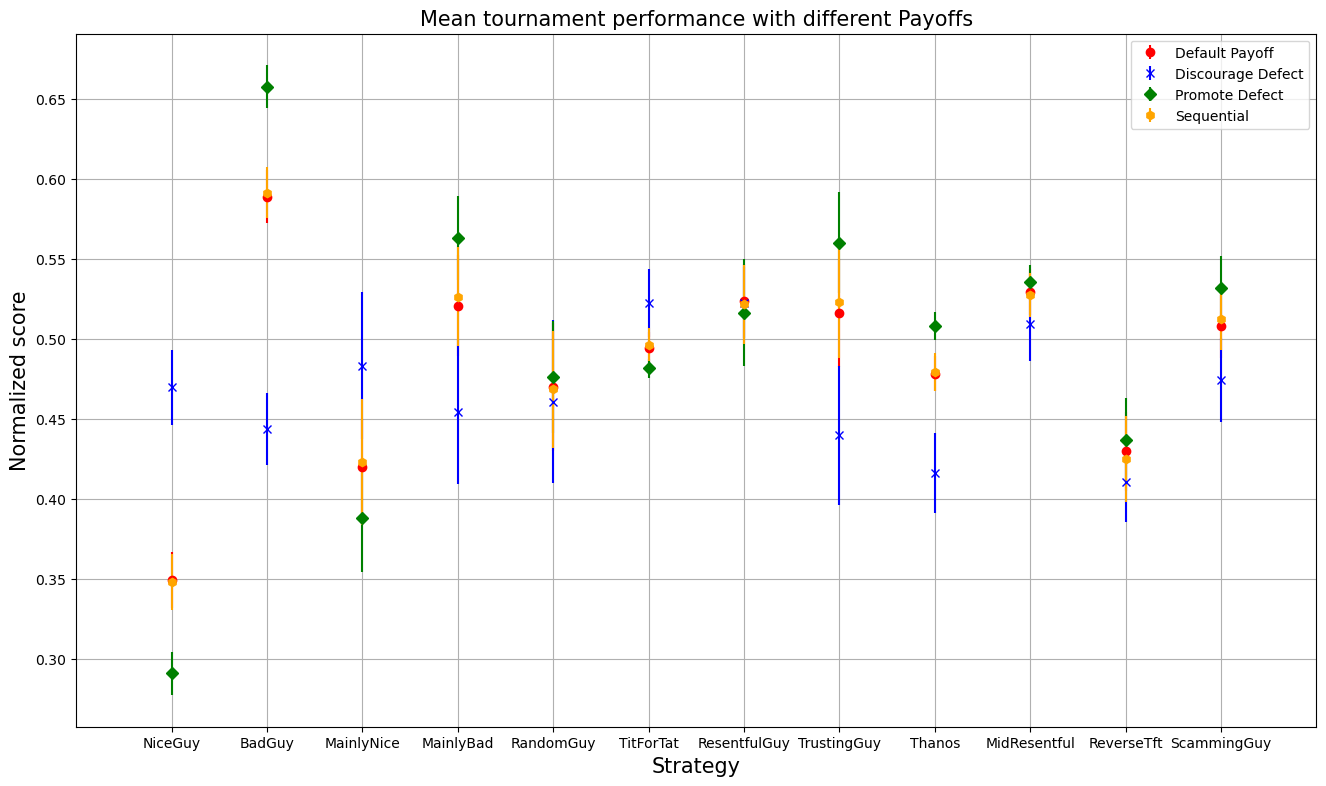

In [14]:
# Scatter plot to visualize results
names = mean_result_df.index
x_vals = np.arange(1,len(names)+1,1)

fig, ax = plt.subplots(figsize=(16,9))
# with my version of matplotlib - 3.9.2 - ls="" is needed to hide lines connecting the dots
ax.errorbar(x_vals, mean_result_df["Mean Score"], yerr =mean_result_df["Mean Error"], label = "Default Payoff", color = "red", marker  = "o",ls='')
ax.errorbar(x_vals, result_Discourage_Defect["Mean Score"], yerr=result_Discourage_Defect["Mean Error"], label = "Discourage Defect", color = "blue", marker = "x",ls='')
ax.errorbar(x_vals, result_Promote_Defect["Mean Score"], yerr=result_Promote_Defect["Mean Error"] ,label = "Promote Defect", color = "green", marker = "D",ls='')
ax.errorbar(x_vals, result_Sequential["Mean Score"], yerr=result_Sequential["Mean Error"] ,label = "Sequential", color = "orange", marker = "h",ls='')
ax.set_title("Mean tournament performance with different Payoffs",fontsize=15)
ax.set_xlabel("Strategy",fontsize=15)
ax.set_xlim(0,len(names)+1)
ax.set_xticks(x_vals)
ax.set_ylabel("Normalized score",fontsize=15)

ax.set_xticklabels(names)
ax.grid()

ax.legend()
plt.show()


## Explore different Payoffs ##
In this section we examine the effect of changing the Payoff matrix in the case of the standard population, varying the coefficients up to MAX_VALUE (which has been set to 30 for the purpose of the presentation and will take some time to run for higher values).

In [15]:
RUN_AGAIN = False
MAX_VALUE = 30

if(RUN_AGAIN):
    coeffs = test_parameters(MAX_VALUE)
    print(len(coeffs))
    # Retrieve the participants to the tourney as the players with non-zero frequency: needed to avoid divisions by zero with the mean
    labels = [ x for (x,f) in test_part.items() if f!=0 ]
    
    # In order to create adataframe to store matrix coefficients, 1st classified's score, 2nd and 3rd classified score differences we use
    # a numpy array to first retrieve the data and then build the dataframe from there: we could use concat, but that basically
    # generates a new dataframe at each iteration, which is not ideal
    
    # Use the "object" type for strings instead of dtype="U#" where # is the maximum chars that our strings will contain because, while slower,
    # it will greatly simplify data type recognition in the pandas dataframe
    winners_strategy = np.empty(shape=(len(coeffs),3),dtype="object")
    winners_scores = np.zeros(shape=(len(coeffs),3),dtype=float)
    # index to go through the above containers
    i = 0
    
    for c in coeffs:
        payoff_matrix = get_new_Payoff(c)
        result_df, top3_df = mean_tourney(test_part,N_rounds = N_ROUNDS, M = payoff_matrix, repeats=20)
        both = pd.concat( (top3_df.sort_values(by=["First [%]"],ascending=False), result_df),axis=1 )
        first, second, third = both.iloc[0].name, both.iloc[1].name, both.iloc[2].name
        winners_strategy[i] = [ first, second, third ]
        winners_scores[i] = [ both["Mean Score"][first], both["Mean Score"][first] - both["Mean Score"][second],
                             both["Mean Score"][first] - both["Mean Score"][third] ]
        i +=1
        
    result_df = pd.DataFrame(np.hstack((coeffs,winners_strategy,winners_scores)),columns=("T","R","P","S","1st Strategy","2nd Strategy",
                                                                                          "3rd Strategy", "1st Score", "From 2nd","From 3rd") )
    # Fix the number of digits showed
    pd.options.display.float_format = '{:.4f}'.format
    display(result_df)
    result_df.to_pickle(f"MaxT-{MAX_VALUE}.pkl")
    #result_df.to_pickle(f"Final-MaxT-{MAX_VALUE}.pkl")

In [16]:
#winners = pd.read_pickle(f"MaxT-{MAX_VALUE}.pkl")
winners = pd.read_pickle(f"Final-MaxT-{MAX_VALUE}.pkl")
winners

,T,R,P,S,1st Strategy,2nd Strategy,3rd Strategy,1st Score,From 2nd,From 3rd
0,3,2,1,0,BadGuy,MainlyBad,TrustingGuy,0.585,0.064,0.053
1,4,3,1,0,BadGuy,MainlyBad,TrustingGuy,0.541,0.022,0.040
2,4,3,2,0,BadGuy,NiceGuy,MainlyNice,0.694,0.294,0.230
3,4,3,2,1,BadGuy,MainlyBad,TrustingGuy,0.589,0.065,0.061
4,5,3,1,0,BadGuy,TrustingGuy,MainlyBad,0.501,0.039,0.049
...,...,...,...,...,...,...,...,...,...,...
23620,30,29,28,23,BadGuy,NiceGuy,MainlyNice,0.826,0.384,0.314
23621,30,29,28,24,BadGuy,NiceGuy,MainlyNice,0.795,0.364,0.278
23622,30,29,28,25,BadGuy,NiceGuy,MainlyNice,0.753,0.340,0.248
23623,30,29,28,26,BadGuy,NiceGuy,MainlyNice,0.694,0.308,0.232


In [17]:
#1st places for strategies in %: get the frequency of first places with size and normalize by the total
ones = winners.groupby(["1st Strategy"]).size()/(winners.groupby(["1st Strategy"]).size().sum())*100
twos = winners.groupby(["2nd Strategy"]).size()/(winners.groupby(["2nd Strategy"]).size().sum())*100
threes = winners.groupby(["3rd Strategy"]).size()/(winners.groupby(["3rd Strategy"]).size().sum())*100

overall_ranking = pd.DataFrame(pd.concat((ones,twos,threes),axis=1) )
overall_ranking.rename(columns={0:"First [%]", 1: "Second [%]", 2: "Third [%]"},inplace=True)
overall_ranking.fillna(value=0, inplace=True)
overall_ranking.sort_values(by=["First [%]"],ascending=False, inplace=True)
overall_ranking

,First [%],Second [%],Third [%]
BadGuy,74.066,3.204,2.971
ResentfulGuy,13.198,16.114,9.325
TitForTat,5.520,5.295,4.859
MidResentful,4.127,9.139,10.154
MainlyBad,1.274,17.130,9.541
TrustingGuy,0.720,10.984,10.764
RandomGuy,0.669,1.922,4.457
MainlyNice,0.419,1.134,37.397
ScammingGuy,0.008,0.085,0.453
NiceGuy,0.000,34.993,10.078


As we can see, the Bad Guy strategy (always defect) is the most successful one for the majority of the Payoff matrixes explored.
However, there are regions in the [T,R,P,S] parameters space where this is not the case, which we visualize below.

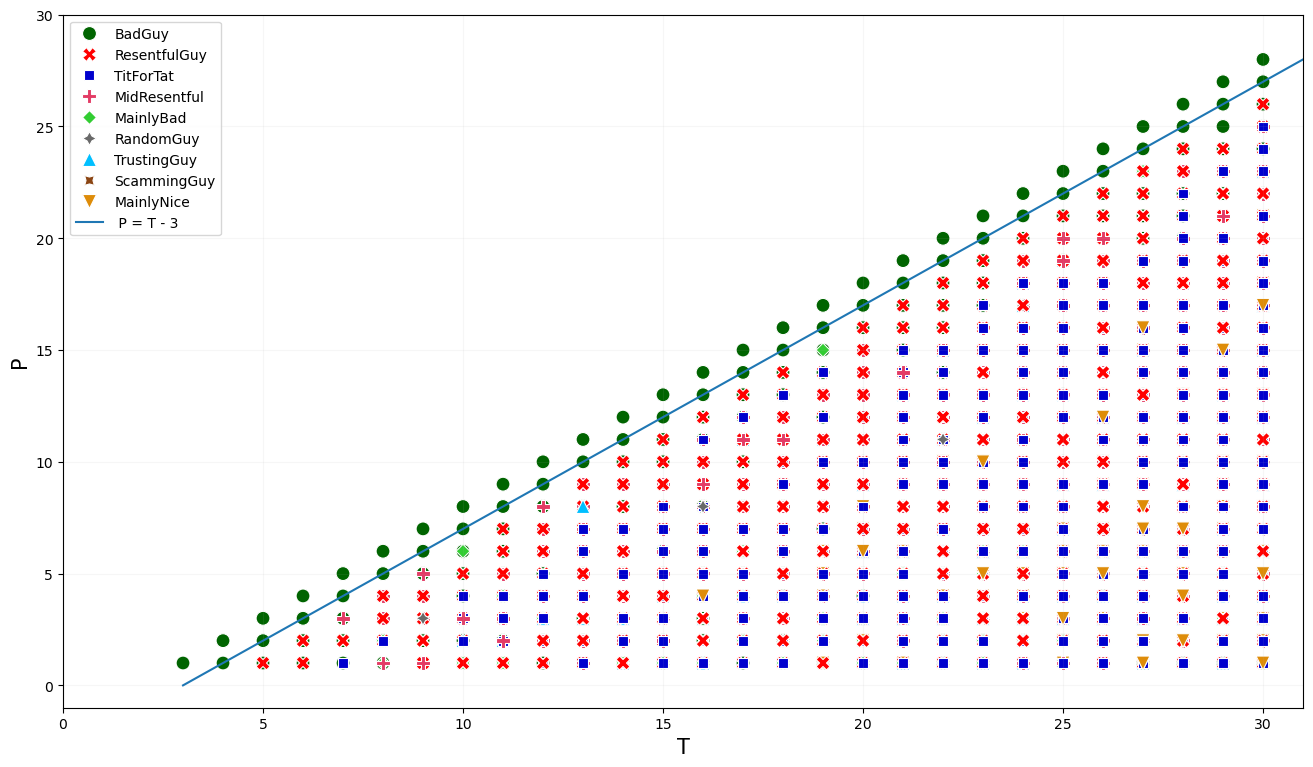

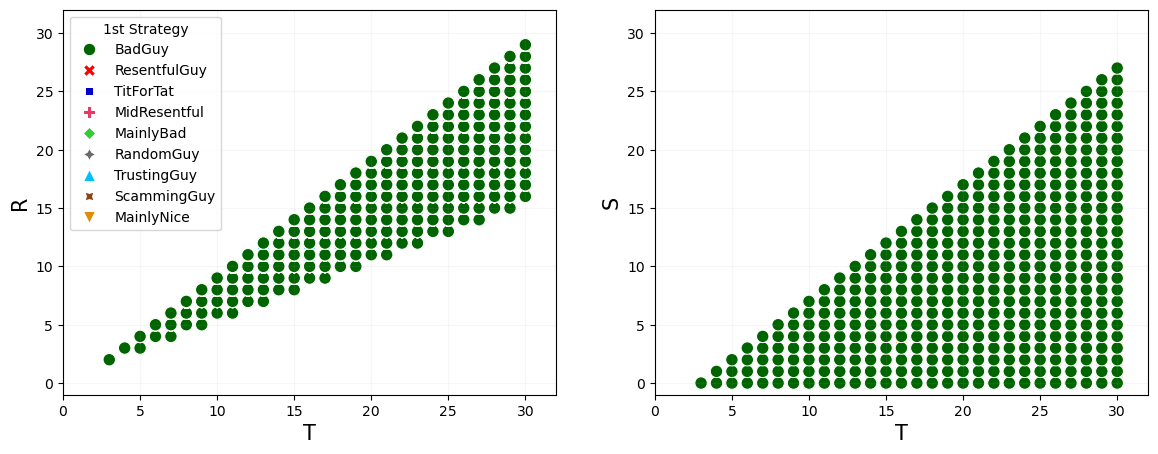

In [26]:
strategy_colors =[
    '#FFD700',  # NiceGuy - Gold
    '#006400',  # BadGuy - Dark Green
    '#DE8C09',  # MainlyNice - Orange/Gold
    '#32CD32',  # MainlyBad - Lime Green
    '#0000CD',  # TitForTat - Dark Blue
    '#696969',  # RandomGuy - Dark Gray
    '#FF0000',  # ResentfulGuy - Red
    '#00BFFF',  # TrustingGuy - Deep Sky Blue
    '#800080',  # BalancingGuy - Purple
    '#E33B65',  # MidResentful - Brown/Red
    '#2E9E98',  # ReverseTitForTat - Copper Blue
    '#8B4513',  # ScammingGuy - Brown/Bronze
]

# creating a dictionary for color to strategy identification
color_dic = dict( zip( list( strategies.keys() ), strategy_colors))

fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlim(0,31)
ax.set_ylim(-1,30)
ax.grid(alpha=0.1)
sns.scatterplot(data=winners,x="T", y="P", hue="1st Strategy", style = "1st Strategy", palette = color_dic, s=100)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
xs = np.linspace(3,31,1000)
ys = xs - 3
ax.plot(xs,ys, label =" P = T - 3 ")
plt.legend()
plt.show()

fig, axs = plt.subplots(1,2, figsize=(14,5))
for i in range(2):
    axs[i].set_xlim(0,32)
    axs[i].set_ylim(-1,32)
    axs[i].grid(alpha=0.1)
    axs[i].xaxis.get_label().set_fontsize(15)
    axs[i].yaxis.get_label().set_fontsize(15)
sns.scatterplot(data=winners,x="T", y="R", hue="1st Strategy", style = "1st Strategy", palette = color_dic, ax=axs[0], s=80 )
sns.scatterplot(data=winners,x="T", y="S", hue="1st Strategy", style = "1st Strategy", palette = color_dic, ax=axs[1] , s=80)
axs[0].get_legend().set_visible(True)
axs[1].get_legend().set_visible(False)
#fig.tight_layout()
plt.show()

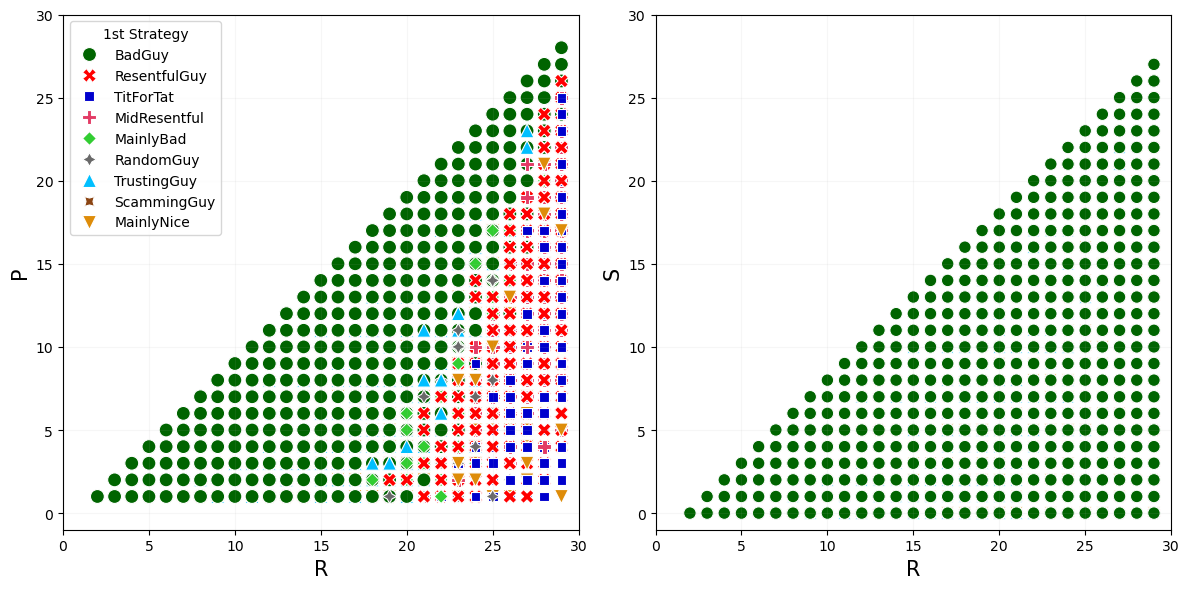

In [19]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
for i in range(2):
    axs[i].set_xlim(0,30)
    axs[i].set_ylim(-1,30)
    axs[i].grid(alpha=0.1)
    axs[i].xaxis.get_label().set_fontsize(15)
    axs[i].yaxis.get_label().set_fontsize(15)
sns.scatterplot(data=winners,x="R", y="P", hue="1st Strategy", style = "1st Strategy", palette = color_dic, ax=axs[0], s=100 )
#plt.show()
sns.scatterplot(data=winners,x="R", y="S", hue="1st Strategy", style = "1st Strategy", palette = color_dic, ax=axs[1], s=80)
#plt.show()
axs[1].get_legend().set_visible(False)
fig.tight_layout()

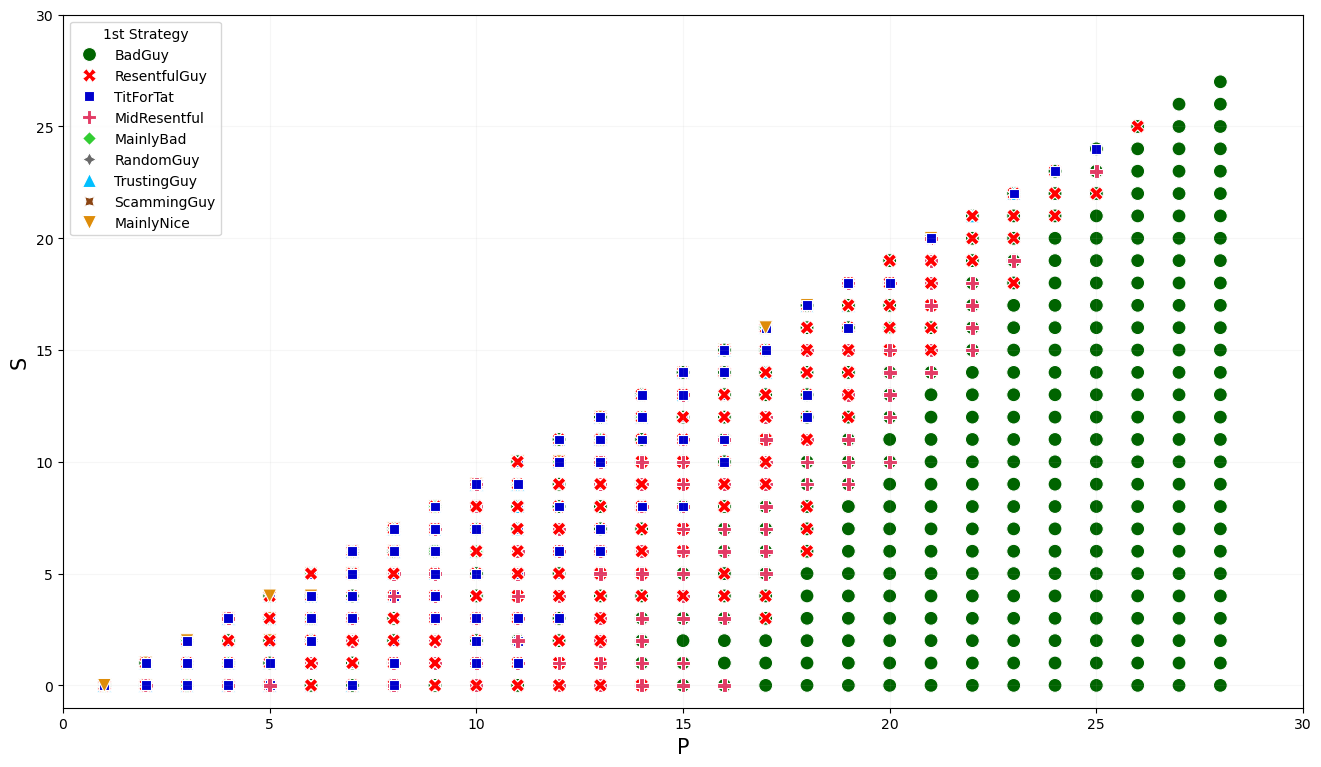

In [29]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlim(0,30)
ax.set_ylim(-1,30)
ax.grid(alpha=0.1)
sns.scatterplot(data=winners,x="P", y="S", hue="1st Strategy", style = "1st Strategy", palette = color_dic, s=100 )
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.show()

In [21]:
#sns.pairplot(data=winners, vars=["T","R","P","S"],kind="scatter", hue="1st Strategy", palette = color_dic, corner=True,diag_kind="hist",plot_kws={"style":winners["1st Strategy"]} )